In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('hw3_course_lead_scoring.csv')

In [4]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
fillvs = {"lead_source":"NA", "industry":"NA", "number_of_courses_viewed":0.0, "annual_income":0.0, 
          "employment_status":"NA", "location":"NA", "interaction_count":0.0, "lead_score":0.0, 
          "converted":0.0}
df = df.fillna(value=fillvs)

In [7]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [115]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [116]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [117]:
df_train = df_train.drop(columns="converted")
df_val = df_val.drop(columns="converted")
df_test = df_test.drop(columns="converted")

In [12]:
from sklearn.metrics import roc_auc_score

In [23]:
columns_cat = ["lead_source", "industry", "employment_status", "location"]
columns_num = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]

In [31]:
for col in columns_num:
#    print(roc_auc_score(y_train, df[col]))
    print('%s: %.2f' % (col, roc_auc_score(y_train, df_train[col])))
    

number_of_courses_viewed: 0.76
annual_income: 0.55
interaction_count: 0.74
lead_score: 0.61


In [92]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
X_val = dv.transform(df_val.to_dict(orient='records'))
roc_auc_score(y_val,model.predict(X_val))

0.647564950627936

In [91]:
thresholds = np.linspace(0, 1, 101)

In [98]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [103]:
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
for idx in range(len(thresholds)):
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = y_pred_proba>=thresholds[idx]
    precisions[idx] = precision_score(y_val, y_pred,zero_division=np.nan)
    recalls[idx] = recall_score(y_val, y_pred)
    f1s[idx] = f1_score(y_val, y_pred)
    #y_pred_proba = model.predict_proba(X_train)[:, 1]
    #y_pred = y_pred_proba>=thresholds[idx]
    #precisions[idx] = precision_score(y_train, y_pred,zero_division=np.nan)
    #recalls[idx] = recall_score(y_train, y_pred)
    #f1s[idx] = f1_score(y_train, y_pred)

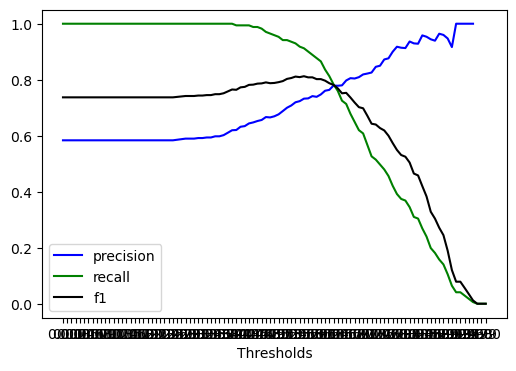

In [107]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, precisions, color='blue')
plt.plot(thresholds, recalls, color='green')
plt.plot(thresholds, f1s, color='black')

plt.xlabel('Thresholds')

plt.legend(['precision', 'recall', 'f1'])

plt.xticks(thresholds)

plt.show()

In [105]:
thresholds[np.abs(recalls-precisions)==np.nanmin(np.abs(recalls-precisions))]

array([0.64])

In [109]:
thresholds[f1s==np.nanmax(f1s)]

array([0.57])

In [110]:
from sklearn.model_selection import KFold

In [111]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [125]:
def train(df, y, C):
    cat = df.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df.to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred_proba = model.predict_proba(X)[:, 1]

    return y_pred_proba

In [126]:
aucs = []

for train_idx, val_idx in kf.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.converted.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, 1.0)
    y_pred_proba = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred_proba)
    aucs.append(rocauc)

In [127]:
np.mean(aucs), np.std(aucs)

(np.float64(0.8757483690012243), np.float64(0.03177873210139216))

In [128]:
aucs

[0.8688304920717635,
 0.9216514191883649,
 0.8433810305731487,
 0.8422322540473225,
 0.9026466491255224]

In [129]:
0.0317787-0.006

0.0257787

In [130]:
0.0317787-0.06

-0.028221299999999998

In [136]:
scores = np.zeros((5,3))
aucs = np.zeros((5,3))
Cs = [0.000001, 0.001, 1]
for cidx in range(3):
    fidx = 0
    for train_idx, val_idx in kf.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        y_train = df_train.converted.values
    
        df_val = df_train_full.iloc[val_idx]
        y_val = df_val.converted.values
    
        dv, model = train(df_train, y_train, Cs[cidx])
        y_pred_proba = predict(df_val, dv, model)

        
        aucs[fidx,cidx] = roc_auc_score(y_val, y_pred_proba)

        cat_val = df_val.to_dict(orient='records')
        X_val = dv.transform(cat_val)
        scores[fidx,cidx] = model.score(X_val,y_val)
        
        fidx = fidx + 1

In [137]:
scores

array([[0.56837607, 0.57264957, 0.76495726],
       [0.62820513, 0.62820513, 0.81196581],
       [0.62820513, 0.63675214, 0.78632479],
       [0.62820513, 0.63247863, 0.78205128],
       [0.60944206, 0.61802575, 0.82832618]])

In [138]:
scores.mean(axis=0)

array([0.6124867 , 0.61762224, 0.79472507])

In [139]:
aucs

array([[0.55773096, 0.91788878, 0.86883049],
       [0.51982172, 0.94745484, 0.92165142],
       [0.59042928, 0.89889749, 0.84338103],
       [0.55923101, 0.92061021, 0.84223225],
       [0.57723263, 0.94575143, 0.90264665]])

In [140]:
aucs.mean(axis=0)

array([0.56088912, 0.92612055, 0.87574837])